## Zero noise extrapolation with mitiq on Amazon Braket

In this notebook, we look at Zero Noise Extrapolation. 



### Basics of Zero Noise Extrapolation

### Setting up our problem 

In [1]:
from mitiq.zne import construct_circuits

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.emulation.local_emulator import LocalEmulator
from qiskit import QuantumCircuit
from qiskit import transpile
import warnings 
warnings.filterwarnings("ignore", category=UserWarning, module="qiskit_braket_provider")

import numpy as np 
from braket.emulation.local_emulator import LocalEmulator
import json

with open("emerald_properties_251106.json","r") as fp:
    props = json.load(fp)

emulator = LocalEmulator.from_json(props)
qd = LocalSimulator("braket_dm",noise_model= emulator._noise_model)

# target = aws_device_to_target(qd)


In [2]:
from mitiq.zne import construct_circuits
from qiskit_braket_provider import to_braket, to_qiskit
from math import pi 

def rxx_pi4(i,j):
    """ implement an Rxx(pi/4) gate from a CNOT """
    cx = Circuit().h(i).cnot(i,j).h(i).rx(i,pi/8).rx(j,pi/8)
    return cx

def ising_1d(self_interaction : float, num_qubits : int) -> Circuit:
    circ = Circuit()
    for i in range(num_qubits):
        circ.ry(i,self_interaction)
    for i in range(0,num_qubits-1,2):
        circ+= rxx_pi4(i,i+1)
    for i in range(1,num_qubits-1,2):
        circ+= rxx_pi4(i,i+1)
    # circ = to_braket(
    #     to_qiskit(
    #         circ, add_measurements=False), 
    #         basis_gates=["cz","r"], 
    #         optimization_level=1)
    return circ

test = ising_1d(0.1,10)
print(test)


T  : │     0      │  1  │  2  │     3      │     4      │  5  │     6      │     7      │
      ┌──────────┐ ┌───┐          ┌───┐     ┌──────────┐                                 
q0 : ─┤ Ry(0.10) ├─┤ H ├───●──────┤ H ├─────┤ Rx(0.39) ├─────────────────────────────────
      └──────────┘ └───┘   │      └───┘     └──────────┘                                 
      ┌──────────┐       ┌─┴─┐ ┌──────────┐    ┌───┐              ┌───┐     ┌──────────┐ 
q1 : ─┤ Ry(0.10) ├───────┤ X ├─┤ Rx(0.39) ├────┤ H ├───────●──────┤ H ├─────┤ Rx(0.39) ├─
      └──────────┘       └───┘ └──────────┘    └───┘       │      └───┘     └──────────┘ 
      ┌──────────┐ ┌───┐          ┌───┐     ┌──────────┐ ┌─┴─┐ ┌──────────┐              
q2 : ─┤ Ry(0.10) ├─┤ H ├───●──────┤ H ├─────┤ Rx(0.39) ├─┤ X ├─┤ Rx(0.39) ├──────────────
      └──────────┘ └───┘   │      └───┘     └──────────┘ └───┘ └──────────┘              
      ┌──────────┐       ┌─┴─┐ ┌──────────┐    ┌───┐              ┌───┐     ┌──────────┐ 
q3 : ─┤ Ry

In [3]:
import matplotlib.pyplot as plt 
from braket.circuits.observables import Z
np.set_printoptions(linewidth=400,precision=3,suppress=True)

qd_exact = LocalSimulator()
obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

circ = Circuit()
ideal_evs = []
ideal_stds = []
for steps in range(10):
    circ+= test + test
    res = qd_exact.run(circ + obs, shots = 0).result()
    ideal_evs.append(res.values)


dat = np.array(ideal_evs)
dat.shape



(10, 10)

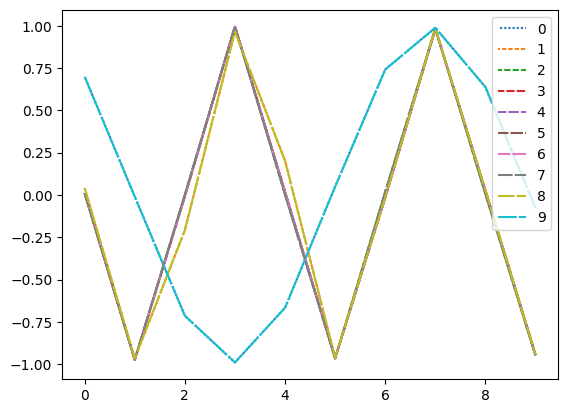

In [4]:
# plt.errorbar(range(len(ideal_evs)), ideal_evs, ideal_stds, capsize=3, marker='x',linewidth=1)
for i in range(10):
    plt.plot(range(10), dat[:,i], label = f'{i}', linestyle = (1,(i+1,1)))
    plt.legend()

In [5]:
obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

noisy_circ = Circuit()
noisy_evs = []
for steps in range(10):
    noisy_circ+= test + test
    ncirc = to_braket(
        to_qiskit(
            noisy_circ, add_measurements=False), 
            basis_gates=["cz","r"], 
            optimization_level=0)

    res = qd.run(ncirc + obs, shots = 10000).result()
    noisy_evs.append(res.values)

noisy_evs = np.array(noisy_evs)

print(noisy_evs)

[[ 0.683  0.066 -0.003  0.013  0.004  0.019  0.007  0.003  0.024  0.599]
 [-0.023 -0.865 -0.782 -0.854 -0.833 -0.714 -0.755 -0.78  -0.728 -0.01 ]
 [-0.67  -0.158  0.004 -0.008 -0.004 -0.019  0.012 -0.011 -0.128 -0.476]
 [-0.924  0.795  0.727  0.805  0.746  0.642  0.666  0.666  0.555 -0.591]
 [-0.613  0.137  0.007  0.006  0.023  0.029  0.007 -0.02   0.107 -0.345]
 [ 0.043 -0.722 -0.649 -0.714 -0.657 -0.534 -0.557 -0.544 -0.417  0.006]
 [ 0.676 -0.003  0.006 -0.013 -0.018  0.002 -0.015  0.005  0.     0.307]
 [ 0.864  0.692  0.604  0.67   0.586  0.457  0.488  0.441  0.32   0.362]
 [ 0.544  0.021 -0.009  0.024  0.011  0.017 -0.003  0.007  0.005  0.198]
 [-0.092 -0.602 -0.54  -0.602 -0.517 -0.394 -0.4   -0.381 -0.25  -0.055]]


Text(0, 0.5, 'Expectation Value')

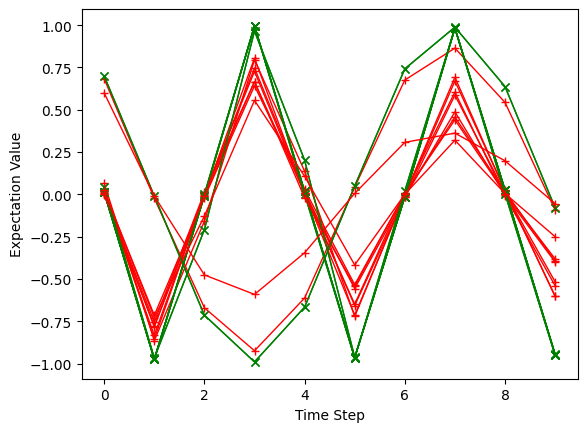

In [6]:
for i in range(10):
    plt.plot(range(10), dat[:,i], marker='x',linewidth=1, c = 'g',
                label=f"ideal: <Z({i})>"
                )
    plt.plot(range(0,len(noisy_evs)), noisy_evs[:,i], marker='+',c='r',linewidth=1,
                label=f"noisy: <Z({i})>")
plt.xlabel("Time Step")
plt.ylabel("Expectation Value")

In [7]:
from mitiq.zne import construct_circuits 
import numpy as np 

obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

circ=  Circuit()
zne_evs = np.zeros((10,3,10))
for steps in range(10):
    circ+= test + test
    circuits = construct_circuits(circ, [1.0, 1.75, 2.5])
    temp = np.zeros((10,3))
    for j,item in enumerate(circuits):
        ncirc = to_braket(
            to_qiskit(
                item, add_measurements=False), 
                basis_gates=["cz","r"], 
                optimization_level=0)

        res = qd.run(ncirc + obs, shots = 10000).result()
        zne_evs[steps,j,:] = res.values

### Performing Extrapolations with mitiq.zne.inference Factories


Now that we have three results, we will look at means of extrapolating these via post processing. In particular, we consider three different fits, a `LinearFactory`, an `ExponentialFactory` and a `RichardsonFactory`. 

The `LinearFactory` performs a simple least-squared fit of the data. 

The `ExpFactory` tries to fit an exponential curve to the data of the form $y(x) = a + b * \exp(-c * x)$, with $c > 0$. Notably, we can also incorporate the infinite limit, which effectively sets $a$, and then allows for a linear regression of the form $log(y(x)) = log(b) - c x$. For common expectation value problems, this is typically the trace of the observable $a = {\rm Tr}[\hat O]$. 

The `RichardsonFactory` performs Richardson extrapolation to fit $n$ data points to a degree $n-1$ polynomial, of which there is a unique solution. Thus it has some nice guarantees, namely there are existing expression for the variance and bias of the resulting estimate we can harness. 


In [8]:
from mitiq.zne import combine_results
from mitiq.zne.inference import RichardsonFactory, ExpFactory, LinearFactory

extrapolated = []
for i in range(10):
    temp = []
    for j in range(10):
        # temp.append(combine_results([1, 1.75, 2.5], zne_evs[i,:,j], RichardsonFactory.extrapolate))
        temp.append(combine_results([1, 1.75, 2.5, 20], zne_evs[i,:,j].tolist() + [0.0], RichardsonFactory.extrapolate))
    extrapolated.append(temp)

extrapolated = np.array(extrapolated)

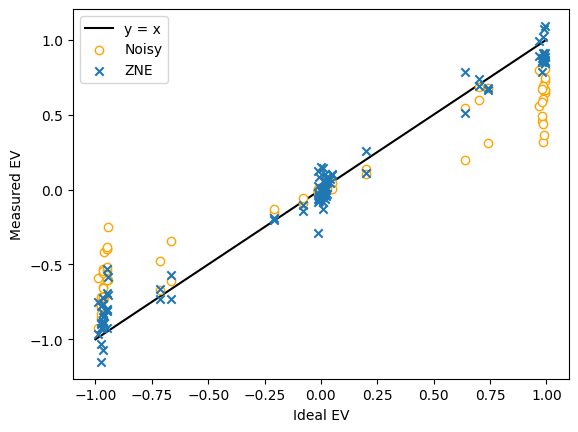

In [9]:
xs = np.linspace(-1,+1,51)
plt.plot(xs,xs,color='k',zorder=0, label="y = x")
plt.scatter(dat.flatten(), noisy_evs.flatten(), marker = 'o', facecolor='w', edgecolor='orange', label="Noisy")
plt.scatter(dat.flatten(), extrapolated.flatten(), label="ZNE", marker = 'x')
plt.xlabel("Ideal EV")
plt.ylabel("Measured EV")
plt.legend()

We can dive deeper into one of these extrapolation techniques using the extrapolate function.

First, let's inspect the noisy expectations themselves:

Text(0, 0.5, 'Expectation Value')

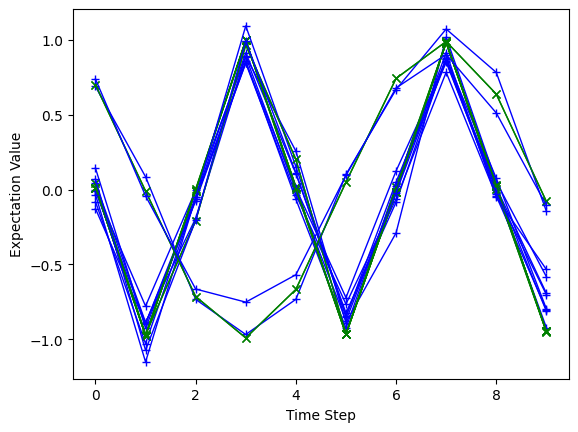

In [10]:
for i in range(10):
    plt.plot(range(10), dat[:,i], marker='x',linewidth=1, c = 'g',
                label=f"ideal: <Z({i})>"
                )
    plt.plot(range(0,len(noisy_evs)), extrapolated[:,i], marker='+',c='b',linewidth=1,
                label=f"noisy: <Z({i})>")
plt.xlabel("Time Step")
plt.ylabel("Expectation Value")

### On Bias and Variance


### References 

## Work in Progress Below - Stop Reading

We can go one step further. Based on the Lagrange interpolation coefficients, we have that:



In [11]:
x0,x1,x2,x3 = 1.0, 2.0, 3.0, 4.0



def norm(xs):
    return np.sum(np.abs(lagrange_coefficients(xs)))

def lagrange_coefficients(xs):
    xs = np.array(xs).tolist()
    xs = [1]+xs
    coeffs = []
    for i, xi in enumerate(xs):
        li = 1
        for j, xj in enumerate(xs):
            if i!=j:
                li*= (xj)/(xj-xi)
        coeffs.append(li)
    return coeffs

from scipy.optimize import minimize


# new = minimize(norm, [2,3,4 ])
# print(new)
# infidelity 0.01 
# then, at 

print(norm([3.0, 100]))
print(lagrange_coefficients([3.0, 10]))



2.0309278350515463
[1.6666666666666667, -0.7142857142857143, 0.047619047619047616]


(0.7332395106545079, None, [-0.0002376024352621205, 0.02524741278519042, -0.15604932100438237, 0.7332395106545079], None, <function PolyFactory.extrapolate.<locals>.zne_curve at 0x141974b80>)
(-0.04039011897545362, None, [9.424941659064365e-05, -0.009739253881570967, 0.03183512344041487, -0.04039011897545362], None, <function PolyFactory.extrapolate.<locals>.zne_curve at 0x147405f80>)
(-0.6620369810193372, None, [0.00016083375676294962, -0.0179110438897155, 0.18938719115224634, -0.6620369810193372], None, <function PolyFactory.extrapolate.<locals>.zne_curve at 0x141987420>)
(-0.7577016567447092, None, [-0.0002154943313219041, 0.02015356746172144, 0.14716358361434326, -0.7577016567447092], None, <function PolyFactory.extrapolate.<locals>.zne_curve at 0x142dfd260>)
(-0.5640479196614461, None, [0.0003106356050893867, -0.03345305914902583, 0.24459034320533005, -0.5640479196614461], None, <function PolyFactory.extrapolate.<locals>.zne_curve at 0x141987600>)
(0.09317566610194204, None, [-6.5

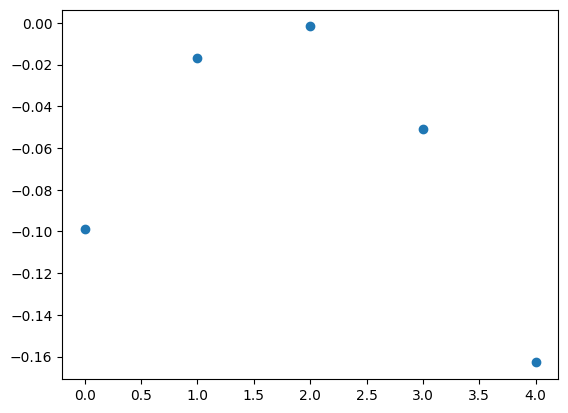

In [12]:
ex_richardson = []
functions = []
factories = []
for i in range(10):
    temp = []
    for j in range(10):
        res = RichardsonFactory.extrapolate(
            [1, 1.75, 2.5,100], zne_evs[i,:,j].tolist() + [0.0], True)
        temp.append(res[0])
        test = RichardsonFactory([1, 1.75, 2.5])
        for n,scale in enumerate([1, 1.75, 2.5]):
            test.push({"scale_factor":scale}, zne_evs[i,n,j])
        factories.append(test)
    functions.append(res[-1])
    print(res)

plt.scatter(range(5), functions[-1](range(5)))



#### Varying Shot Counts with Richardson Extrapolation 

test

ValueError: Data is either ill-defined or not enough to evaluate the required information. Please make sure that the 'run' and 'reduce' methods have been called and that enough expectation values have been measured.

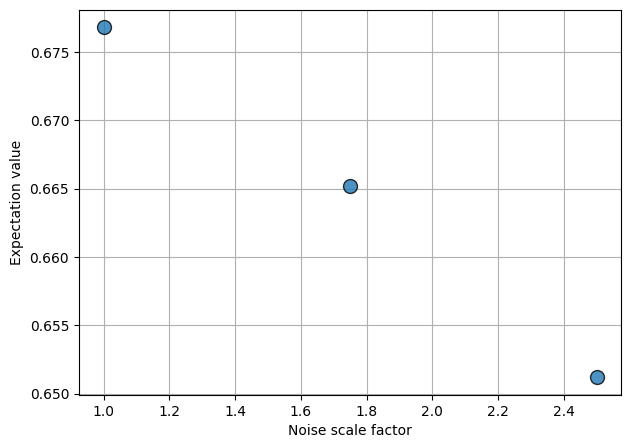

In [13]:
factories[0].plot_fit()

Circuit('instructions': [Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(2)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(3)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(4)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target': QubitSet([Qubit(5)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Ry('angle': 0.1, 'qubit_count': 1), 'target':

In [ ]:
x = ([0.004,0.005,0.006,0.007])
y = ([0.001,0.095,0.026,0.307])

np.polyfit(x,y,3)

array([85500000.   , -1364000.   ,     7154.5  ,      -12.265])

/var/folders/1_/bfh8x9qn75164y0b808mvhrh0000gq/T/ipykernel_18654/3444346918.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f, xs, ys)


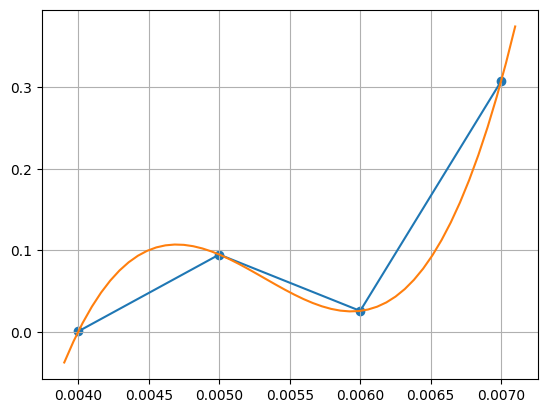

[85500000.    -1364000.        7154.5        -12.265]


In [ ]:
# Source - https://stackoverflow.com/a
# Posted by Péter Leéh
# Retrieved 2025-11-18, License - CC BY-SA 4.0

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

#def a function
def f(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

#convert your data to np arrays
xs = np.array([0.004,0.005,0.006,0.007])
ys = np.array([0.001,0.095,0.026,0.307])

#do the fitting
popt, pcov = curve_fit(f, xs, ys)

#plot the results
plt.figure()
plt.scatter(xs,ys)
plt.plot(xs, f(xs, *popt))

plt.plot(np.linspace(0.0039, 0.0071,50), f(np.linspace(0.0039, 0.0071,50), *popt))
plt.grid()
plt.show()

#the parameters
print(popt)
#outputs [ 7.68289022e+06 -7.34702147e+04  1.79106740e+02]


In [ ]:
# lagrange ? 
x0,x1,x2,x3 = xs

g0 = (x1/(x1-x0))*(x2/(x2-x0))*(x3/(x3-x0))
g1 = (x0/(x0-x1))*(x2/(x2-x1))*(x3/(x3-x1))
g2 = (x0/(x0-x2))*(x1/(x1-x2))*(x3/(x3-x2))
g3 = (x0/(x0-x3))*(x2/(x2-x3))*(x1/(x1-x3))
print(g0,g1,g2,g3)

35.0 -84.0 70.0 -20.0


In [ ]:
import numpy as np
# input
x = xs  # <- x's
y = ys  # <- y's
# calculating coefficients
M = [[_x**i*(-1)**(i*len(x)) for _x in x] for i in range(len(x))]
C = [np.linalg.det((M+[y]+M)[d:d+len(x)]) for d in range(len(x)+1)]
C = (C / C[0] * (-1)**(len(x)+1) )[1:]
# polynomial lambda-function
poly = lambda _x: sum([C[i] * _x**i for i in range(len(x))])
# output and tests
print("Coefficients:\n", C)
print("TESTING:")
for _x, _y in zip(x, y):
    result = "[OK]" if np.allclose(_y, poly(_x)) else "[ERROR]"
    print(_x, " mapped to: ", poly(_x), " ; expected: ", _y, result)

Coefficients:
 [     -12.265     7154.5   -1364000.    85500000.   ]
TESTING:
0.004  mapped to:  0.001000000000110468  ; expected:  0.001 [OK]
0.005  mapped to:  0.09500000000012321  ; expected:  0.095 [OK]
0.006  mapped to:  0.026000000000138357  ; expected:  0.026 [OK]
0.007  mapped to:  0.3070000000001478  ; expected:  0.307 [OK]


#### Further References